In [71]:
import sys
import os
from pathlib import Path
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

sys.path.append(os.path.abspath('..'))

from src.data_loader import load_data
from src.config import (
    OUTPUT_DIR,
    RANDOM_SEED,
    FIGURES_DIR,
    RESULTS_DIR,
    NUMERICAL_FEATURES,
    CATEGORICAL_FEATURES,
    ORDINAL_FEATURES,
    TARGET_FEATURE,
    ALL_FEATURES,
    Color
)

np.random.seed(RANDOM_SEED)

sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

In [2]:
train_df, test_df = load_data()

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"\nTrain columns: {list(train_df.columns)}")

Loading training data from /Users/kryspin/personal/playground/recruitment/challengING_DS/ing_task/data/train.parquet
Loading test data from /Users/kryspin/personal/playground/recruitment/challengING_DS/ing_task/data/test.parquet
Train shape: (20000, 11)
Test shape: (5000, 11)
Train shape: (20000, 11)
Test shape: (5000, 11)

Train columns: ['Age', 'Income', 'CreditScore', 'LoanAmount', 'EmploymentYears', 'NumDependents', 'DebtToIncome', 'EducationLevel', 'FavoriteColor', 'Hobby', 'Default']


In [3]:
print("Negative values BEFORE fix:")
print(f"Income < 0: {(train_df['Income'] < 0).sum()} records")
print(f"LoanAmount < 0: {(train_df['LoanAmount'] < 0).sum()} records")

# Show examples
if (train_df['Income'] < 0).sum() > 0:
    print("\nExample negative values:")
    negative_records = train_df[(train_df['Income'] < 0) | (train_df['LoanAmount'] < 0)]
    print(negative_records[['Income', 'LoanAmount', 'Default']].head())

Negative values BEFORE fix:
Income < 0: 11 records
LoanAmount < 0: 2 records

Example negative values:
            Income    LoanAmount  Default
2286  -4528.003413  24682.121752        0
3477  19346.924692   -788.669387        1
5338    -38.523242  13657.715739        0
6798  -7845.629939  19616.180081        1
6976    -23.390659  16819.988884        0


In [5]:
def fix_negative_values(df):
    """
    Fix negative Income and LoanAmount values.
    
    Based on Phase 1 EDA: 13 records had accidental negative signs.
    Magnitudes are plausible when converted to positive.
    """
    df = df.copy()
    df['Income'] = df['Income'].abs()
    df['LoanAmount'] = df['LoanAmount'].abs()
    return df

# Apply fix to both train and test
train_df = fix_negative_values(train_df)
test_df = fix_negative_values(test_df)

print("Quality fixes applied")

Quality fixes applied


In [6]:
print("Negative values AFTER fix:")
print(f"Income < 0: {(train_df['Income'] < 0).sum()} records")
print(f"LoanAmount < 0: {(train_df['LoanAmount'] < 0).sum()} records")

# Verify test set too
print(f"\nTest set - Income < 0: {(test_df['Income'] < 0).sum()} records")
print(f"Test set - LoanAmount < 0: {(test_df['LoanAmount'] < 0).sum()} records")

assert (train_df['Income'] < 0).sum() == 0, "Still have negative Income values!"
assert (train_df['LoanAmount'] < 0).sum() == 0, "Still have negative LoanAmount values!"
assert (test_df['Income'] < 0).sum() == 0, "Test set has negative Income values!"
assert (test_df['LoanAmount'] < 0).sum() == 0, "Test set has negative LoanAmount values!"

print("\nAll assertions passed - no negative values remain")

Negative values AFTER fix:
Income < 0: 0 records
LoanAmount < 0: 0 records

Test set - Income < 0: 0 records
Test set - LoanAmount < 0: 0 records

All assertions passed - no negative values remain


In [7]:
X_train = train_df.drop(columns=[TARGET_FEATURE])
y_train = train_df[TARGET_FEATURE]

X_test = test_df.drop(columns=[TARGET_FEATURE])
y_test = test_df[TARGET_FEATURE]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"\nX_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

print(f"\ny_train distribution:")
print(y_train.value_counts(normalize=True))

X_train shape: (20000, 10)
y_train shape: (20000,)

X_test shape: (5000, 10)
y_test shape: (5000,)

y_train distribution:
Default
0    0.65685
1    0.34315
Name: proportion, dtype: float64


In [10]:
print("Missing values in X_train:")
missing_train = X_train.isnull().sum()
print(missing_train[missing_train > 0])

# CredutScore sum
cs_sum = X_train['CreditScore'].isnull().sum()

print(f"\nCreditScore missing: {cs_sum} / {len(X_train)} ({cs_sum/len(X_train)*100:.2f}%)")

Missing values in X_train:
CreditScore    2383
dtype: int64

CreditScore missing: 2383 / 20000 (11.92%)


In [17]:
print("="*80)
print("SECTION B: Pipeline A - Recommended (No Categoricals)")
print("="*80)

# Based on Phase 1 EDA findings:
# - FavoriteColor: Chi-square p=0.879 (no predictive value)
# - Hobby: Chi-square p=0.636 (no predictive value)
# Decision: EXCLUDE both categorical features

FEATURES_TO_DROP_A = CATEGORICAL_FEATURES  # ['FavoriteColor', 'Hobby']

print(f"\nPipeline A Configuration:")
print(f"  Numerical features (will be scaled): {len(NUMERICAL_FEATURES)}")
print(f"  Ordinal features (NOT scaled): {len(ORDINAL_FEATURES)}")
print(f"  Categorical features to drop: {len(FEATURES_TO_DROP_A)}")
print(f"  Total features in Pipeline A: {len(NUMERICAL_FEATURES) + len(ORDINAL_FEATURES)}")

print(f"\nNumerical features (scaled):")
for i, feat in enumerate(NUMERICAL_FEATURES, 1):
    print(f"  {i}. {feat}")

print(f"\nOrdinal features (NOT scaled, kept as 1-4):")
for i, feat in enumerate(ORDINAL_FEATURES, 1):
    print(f"  {i}. {feat}")

print(f"\nFeatures to drop:")
for i, feat in enumerate(FEATURES_TO_DROP_A, 1):
    print(f"  {i}. {feat}")

SECTION B: Pipeline A - Recommended (No Categoricals)

Pipeline A Configuration:
  Numerical features (will be scaled): 7
  Ordinal features (NOT scaled): 1
  Categorical features to drop: 2
  Total features in Pipeline A: 8

Numerical features (scaled):
  1. Age
  2. Income
  3. CreditScore
  4. LoanAmount
  5. EmploymentYears
  6. NumDependents
  7. DebtToIncome

Ordinal features (NOT scaled, kept as 1-4):
  1. EducationLevel

Features to drop:
  1. FavoriteColor
  2. Hobby


In [18]:
print("\nBuilding Pipeline A...")

# Numerical pipeline: Imputation + Scaling
# - Median imputation for CreditScore missing values (~12%)
# - StandardScaler to normalize all 7 numerical features
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Ordinal pipeline: Imputation only (NO scaling)
# - EducationLevel stays as 1, 2, 3, 4 (preserves ordinal nature)
# - Most_frequent imputation
ordinal_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
    # No StandardScaler - keep original 1-4 values
])

preprocessor_A = ColumnTransformer([
    ('numerical', numerical_pipeline, NUMERICAL_FEATURES),  
    ('ordinal', ordinal_pipeline, ORDINAL_FEATURES)        
], remainder='drop')

pipeline_A = Pipeline([
    ('preprocessor', preprocessor_A)
])

print("Pipeline A created")
print(f"\nPipeline structure:")
print(pipeline_A)


Building Pipeline A...
Pipeline A created

Pipeline structure:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Income',
                                                   'CreditScore', 'LoanAmount',
                                                   'EmploymentYears',
                                                   'NumDependents',
                                                   'DebtToIncome']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('imputer',
 

In [22]:
print("\nFitting Pipeline A on training data...")
print(f"  Training samples: {X_train.shape[0]}")
print(f"  Input features: {X_train.shape[1]}")

# fit only on training data to prevent data leakage
pipeline_A.fit(X_train)

print("Pipeline A fitted")

# get learned parameters for inspection
num_imputer = pipeline_A.named_steps['preprocessor'].named_transformers_['numerical'].named_steps['imputer']
num_scaler = pipeline_A.named_steps['preprocessor'].named_transformers_['numerical'].named_steps['scaler']
ord_imputer = pipeline_A.named_steps['preprocessor'].named_transformers_['ordinal'].named_steps['imputer']

print(f"\nLearned parameters (Numerical features - 7 features):")
print(f"  Imputation values (medians):")
for i, feat in enumerate(NUMERICAL_FEATURES):
    print(f"    {feat:20s}: {num_imputer.statistics_[i]:.2f}")

print(f"\n  Scaling parameters (means):")
for i, feat in enumerate(NUMERICAL_FEATURES):
    print(f"    {feat:20s}: {num_scaler.mean_[i]:.2f}")

print(f"\n  Scaling parameters (stds):")
for i, feat in enumerate(NUMERICAL_FEATURES):
    print(f"    {feat:20s}: {num_scaler.scale_[i]:.2f}")

print(f"\nLearned parameters (Ordinal features - 1 feature):")
print(f"  Imputation values (most frequent):")
for i, feat in enumerate(ORDINAL_FEATURES):
    print(f"    {feat:20s}: {ord_imputer.statistics_[i]:.0f} (kept as-is, not scaled)")


Fitting Pipeline A on training data...
  Training samples: 20000
  Input features: 10
Pipeline A fitted

Learned parameters (Numerical features - 7 features):
  Imputation values (medians):
    Age                 : 45.00
    Income              : 50084.10
    CreditScore         : 575.00
    LoanAmount          : 20046.23
    EmploymentYears     : 19.00
    NumDependents       : 2.00
    DebtToIncome        : 0.50

  Scaling parameters (means):
    Age                 : 44.96
    Income              : 50008.73
    CreditScore         : 574.22
    LoanAmount          : 20030.84
    EmploymentYears     : 19.37
    NumDependents       : 1.99
    DebtToIncome        : 0.50

  Scaling parameters (stds):
    Age                 : 14.08
    Income              : 15004.60
    CreditScore         : 149.26
    LoanAmount          : 4990.69
    EmploymentYears     : 11.55
    NumDependents       : 1.41
    DebtToIncome        : 0.29

Learned parameters (Ordinal features - 1 feature):
  Imputati

In [24]:
print("\nTransforming data with Pipeline A...")

# transform training data
X_train_A = pipeline_A.transform(X_train)
print(f"  X_train_A shape: {X_train_A.shape}")

# transform test data using training parameters
X_test_A = pipeline_A.transform(X_test)
print(f"  X_test_A shape: {X_test_A.shape}")

print("\nData transformation complete")


Transforming data with Pipeline A...
  X_train_A shape: (20000, 8)
  X_test_A shape: (5000, 8)

Data transformation complete


In [30]:
# Cell 12: Validate Pipeline A outputs
print("\n" + "="*80)
print("PIPELINE A VALIDATION")
print("="*80)

# Get feature names in correct order
FEATURES_PIPELINE_A = NUMERICAL_FEATURES + ORDINAL_FEATURES

# Check 1: Correct shapes
print("\n1. Shape validation:")
assert X_train_A.shape == (20000, 8), f"Expected (20000, 8), got {X_train_A.shape}"
assert X_test_A.shape == (5000, 8), f"Expected (5000, 8), got {X_test_A.shape}"
print(f"X_train_A: {X_train_A.shape}")
print(f"X_test_A: {X_test_A.shape}")

# Check 2: No missing values
train_A_df = pd.DataFrame(X_train_A, columns=FEATURES_PIPELINE_A)
test_A_df = pd.DataFrame(X_test_A, columns=FEATURES_PIPELINE_A)

missing_train = train_A_df.isnull().sum().sum()
missing_test = test_A_df.isnull().sum().sum()

print(f"\n2. Missing value validation:")
assert missing_train == 0, f"Training data has {missing_train} missing values!"
assert missing_test == 0, f"Test data has {missing_test} missing values!"
print(f"X_train_A: 0 missing values")
print(f"X_test_A: 0 missing values")

# Check 3: Scaling validation for NUMERICAL features only (first 7 columns)
print(f"\n3. Scaling validation (NUMERICAL features only - first 7 columns):")
numerical_data = train_A_df[NUMERICAL_FEATURES]
means = numerical_data.mean()
stds = numerical_data.std()

print(f"\n  Feature means (should be ~0):")
for feat, mean in means.items():
    print(f"    {feat:20s}: {mean:8.6f}")

print(f"\n  Feature stds (should be ~1):")
for feat, std in stds.items():
    print(f"    {feat:20s}: {std:8.6f}")

# Verify means are close to 0 (within tolerance)
max_mean = abs(means).max()
print(f"\n  Max absolute mean: {max_mean:.6f}")
assert max_mean < 1e-10, f"Means not close to 0! Max: {max_mean}"
print(f"All numerical means < 1e-10 (effectively zero)")

# Verify stds are close to 1 (within tolerance)
std_range = stds.max() - stds.min()
print(f"  Std range: {std_range:.6f}")
assert stds.min() > 0.99 and stds.max() < 1.01, f"Stds not close to 1! Range: [{stds.min()}, {stds.max()}]"
print(f"All numerical stds ∈ [0.99, 1.01]")

# Check 4: Ordinal feature validation (column 8)
print(f"\n4. ORDINAL feature validation (EducationLevel - NOT scaled):")
ordinal_data = train_A_df[ORDINAL_FEATURES]

for feat in ORDINAL_FEATURES:
    unique_vals = sorted(ordinal_data[feat].unique())
    print(f"  {feat}:")
    print(f"    Unique values: {unique_vals}")
    print(f"    Range: [{ordinal_data[feat].min():.0f}, {ordinal_data[feat].max():.0f}]")
    print(f"    Mean: {ordinal_data[feat].mean():.2f} (should be ~2.5 for 1-4 scale)")
    
    # Verify values are in expected range (1-4)
    assert ordinal_data[feat].min() >= 1, f"{feat} has values < 1!"
    assert ordinal_data[feat].max() <= 4, f"{feat} has values > 4!"
    print(f"Values in expected range [1, 4]")

print("\n" + "="*80)
print("PIPELINE A VALIDATION PASSED - ALL CHECKS SUCCESSFUL")
print("="*80)


PIPELINE A VALIDATION

1. Shape validation:
X_train_A: (20000, 8)
X_test_A: (5000, 8)

2. Missing value validation:
X_train_A: 0 missing values
X_test_A: 0 missing values

3. Scaling validation (NUMERICAL features only - first 7 columns):

  Feature means (should be ~0):
    Age                 : -0.000000
    Income              : -0.000000
    CreditScore         : -0.000000
    LoanAmount          : 0.000000
    EmploymentYears     : -0.000000
    NumDependents       : 0.000000
    DebtToIncome        : -0.000000

  Feature stds (should be ~1):
    Age                 : 1.000025
    Income              : 1.000025
    CreditScore         : 1.000025
    LoanAmount          : 1.000025
    EmploymentYears     : 1.000025
    NumDependents       : 1.000025
    DebtToIncome        : 1.000025

  Max absolute mean: 0.000000
All numerical means < 1e-10 (effectively zero)
  Std range: 0.000000
All numerical stds ∈ [0.99, 1.01]

4. ORDINAL feature validation (EducationLevel - NOT scaled):
  Ed


Generating Pipeline A output visualizations...


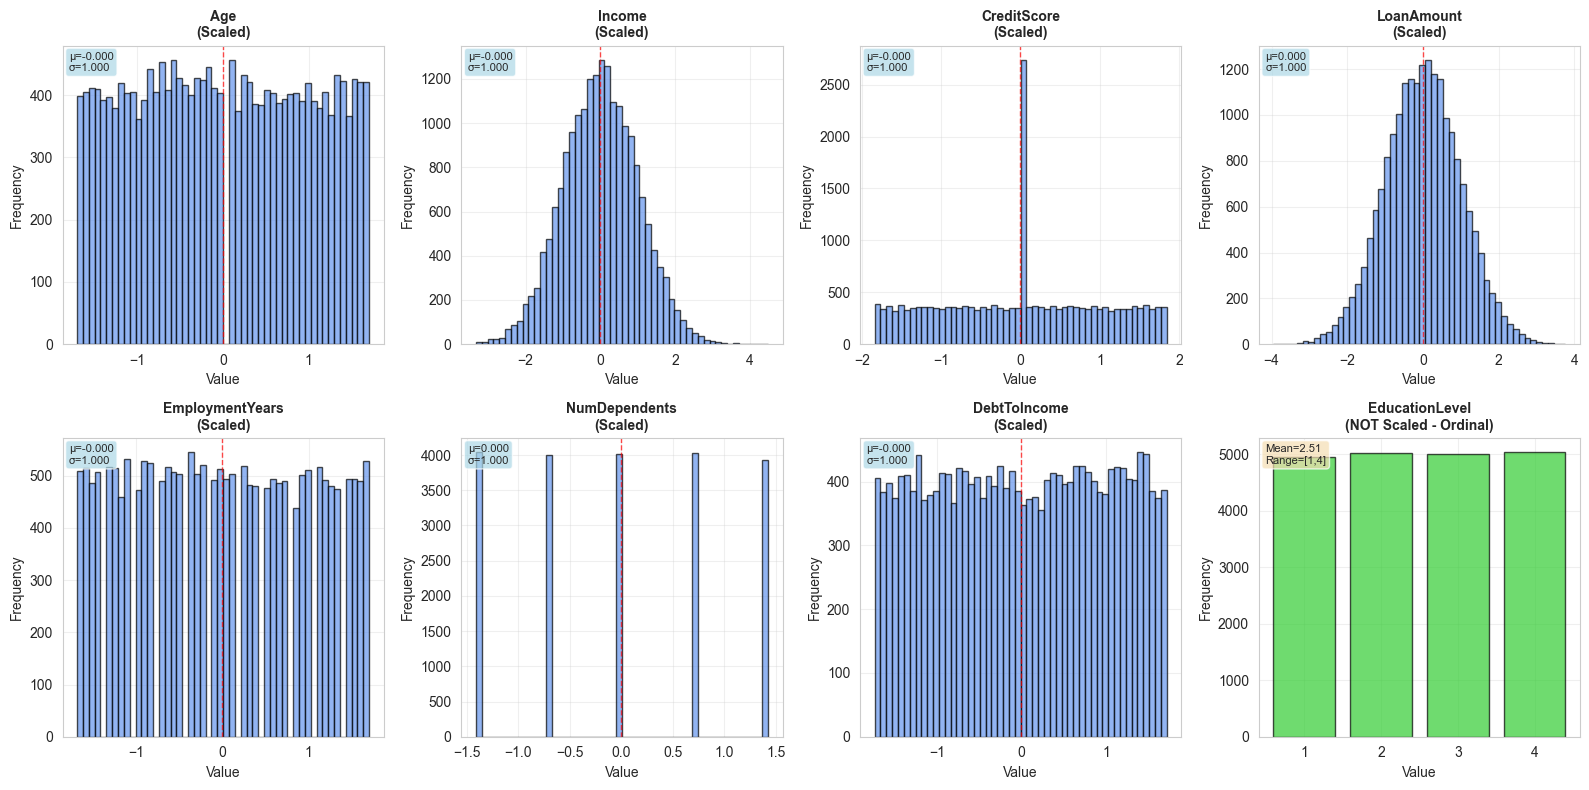

Visualization saved to /Users/kryspin/personal/playground/recruitment/challengING_DS/ing_task/output/figures/02_pipeline_A_distributions.png

Note: Blue histograms = Scaled numerical features (mean=0, std=1)
      Green histogram = Ordinal feature (kept as 1-4)


In [55]:
print("\nGenerating Pipeline A output visualizations...")

FEATURES_PIPELINE_A = NUMERICAL_FEATURES + ORDINAL_FEATURES

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for idx, feature in enumerate(FEATURES_PIPELINE_A):
    ax = axes[idx]
    
    is_numerical = feature in NUMERICAL_FEATURES
    
    if is_numerical:
        # numerical features: expect mean=0, std=1
        ax.hist(train_A_df[feature], bins=50, alpha=0.7, color=Color.BLUE.value, edgecolor='black')
        ax.set_title(f'{feature}\n(Scaled)', fontsize=10, fontweight='bold')
        ax.axvline(0, color='red', linestyle='--', linewidth=1, alpha=0.7, label='Mean=0')
        
        mean = train_A_df[feature].mean()
        std = train_A_df[feature].std()
        ax.text(0.02, 0.98, f'μ={mean:.3f}\nσ={std:.3f}', 
                transform=ax.transAxes, fontsize=8,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
    else:
        # ordinal features: expect values in original range (1-4)
        ax.hist(train_A_df[feature], bins=np.arange(0.5, 5.5, 1), 
                alpha=0.7, color=Color.GREEN.value, edgecolor=Color.BLACK.value, rwidth=0.8)
        ax.set_title(f'{feature}\n(NOT Scaled - Ordinal)', fontsize=10, fontweight='bold')
        ax.set_xticks([1, 2, 3, 4])
        
        mean = train_A_df[feature].mean()
        counts = train_A_df[feature].value_counts().sort_index()
        ax.text(0.02, 0.98, f'Mean={mean:.2f}\nRange=[1,4]', 
                transform=ax.transAxes, fontsize=8,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
    
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / '02_pipeline_A_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Visualization saved to {FIGURES_DIR / '02_pipeline_A_distributions.png'}")
print(f"\nNote: Blue histograms = Scaled numerical features (mean=0, std=1)")
print(f"      Green histogram = Ordinal feature (kept as 1-4)")

In [35]:
print("\n" + "="*80)
print("PIPELINE A SUMMARY")
print("="*80)

FEATURES_PIPELINE_A = NUMERICAL_FEATURES + ORDINAL_FEATURES

print("\nNUMERICAL FEATURES (Scaled - Mean≈0, Std≈1):")
num_summary = pd.DataFrame({
    'Feature': NUMERICAL_FEATURES,
    'Mean': train_A_df[NUMERICAL_FEATURES].mean().round(6),
    'Std': train_A_df[NUMERICAL_FEATURES].std().round(6),
    'Min': train_A_df[NUMERICAL_FEATURES].min().round(2),
    'Max': train_A_df[NUMERICAL_FEATURES].max().round(2),
    'Missing': [0] * len(NUMERICAL_FEATURES)
})
print(num_summary.to_string(index=False))

print("\nORDINAL FEATURES (NOT Scaled - Kept as 1-4):")
ord_summary = pd.DataFrame({
    'Feature': ORDINAL_FEATURES,
    'Mean': train_A_df[ORDINAL_FEATURES].mean().round(2),
    'Std': train_A_df[ORDINAL_FEATURES].std().round(2),
    'Min': train_A_df[ORDINAL_FEATURES].min().round(0),
    'Max': train_A_df[ORDINAL_FEATURES].max().round(0),
    'Missing': [0] * len(ORDINAL_FEATURES)
})
print(ord_summary.to_string(index=False))


PIPELINE A SUMMARY

NUMERICAL FEATURES (Scaled - Mean≈0, Std≈1):
        Feature  Mean      Std   Min  Max  Missing
            Age  -0.0 1.000025 -1.70 1.71        0
         Income  -0.0 1.000025 -3.33 4.48        0
    CreditScore  -0.0 1.000025 -1.84 1.84        0
     LoanAmount   0.0 1.000025 -3.95 3.76        0
EmploymentYears  -0.0 1.000025 -1.68 1.70        0
  NumDependents   0.0 1.000025 -1.41 1.42        0
   DebtToIncome  -0.0 1.000025 -1.74 1.72        0

ORDINAL FEATURES (NOT Scaled - Kept as 1-4):
       Feature  Mean  Std  Min  Max  Missing
EducationLevel  2.51 1.12  1.0  4.0        0


In [36]:
print("\n" + "="*80)
print("SECTION C: Pipeline B - Full (With One-Hot Encoding)")
print("="*80)

# Pipeline B includes ALL features for empirical comparison
# Even though EDA showed FavoriteColor and Hobby have no predictive value,
# we'll test both pipelines to confirm empirically

print(f"\nPipeline B Configuration:")
print(f"  Numerical features (scaled): {len(NUMERICAL_FEATURES)}")
print(f"  Ordinal features (NOT scaled): {len(ORDINAL_FEATURES)}")
print(f"  Categorical features (one-hot encoded): {len(CATEGORICAL_FEATURES)}")

print(f"\nNumerical features (scaled):")
for i, feat in enumerate(NUMERICAL_FEATURES, 1):
    print(f"  {i}. {feat}")

print(f"\nOrdinal features (NOT scaled):")
for i, feat in enumerate(ORDINAL_FEATURES, 1):
    print(f"  {i}. {feat}")

print(f"\nCategorical features (one-hot encoded):")
for i, feat in enumerate(CATEGORICAL_FEATURES, 1):
    categories = sorted(X_train[feat].unique())
    print(f"  {i}. {feat}: {categories} → {len(categories)} categories")

print(f"\nExpected output features:")
print(f"  - Numerical: {len(NUMERICAL_FEATURES)}")
print(f"  - Ordinal: {len(ORDINAL_FEATURES)}")
print(f"  - Categorical (one-hot, drop first):")
for feat in CATEGORICAL_FEATURES:
    n_cats = len(X_train[feat].unique())
    print(f"      {feat}: {n_cats} categories → {n_cats - 1} features (drop first)")
print(f"  - TOTAL: {len(NUMERICAL_FEATURES) + len(ORDINAL_FEATURES) + (len(X_train['FavoriteColor'].unique())-1) + (len(X_train['Hobby'].unique())-1)} features")


SECTION C: Pipeline B - Full (With One-Hot Encoding)

Pipeline B Configuration:
  Numerical features (scaled): 7
  Ordinal features (NOT scaled): 1
  Categorical features (one-hot encoded): 2

Numerical features (scaled):
  1. Age
  2. Income
  3. CreditScore
  4. LoanAmount
  5. EmploymentYears
  6. NumDependents
  7. DebtToIncome

Ordinal features (NOT scaled):
  1. EducationLevel

Categorical features (one-hot encoded):
  1. FavoriteColor: ['Blue', 'Green', 'Red', 'Yellow'] → 4 categories
  2. Hobby: ['Gaming', 'Reading', 'Sports', 'Traveling'] → 4 categories

Expected output features:
  - Numerical: 7
  - Ordinal: 1
  - Categorical (one-hot, drop first):
      FavoriteColor: 4 categories → 3 features (drop first)
      Hobby: 4 categories → 3 features (drop first)
  - TOTAL: 14 features


In [39]:
print("\nBuilding Pipeline B...")

numerical_pipeline_B = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

ordinal_pipeline_B = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

# Categorical pipeline: One-hot encoding
# drop='first' prevents multicollinearity (drops first category as reference)
# sparse_output=False returns dense array 
# handle_unknown='ignore' handles categories in test not seen in train
categorical_pipeline_B = Pipeline([
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

preprocessor_B = ColumnTransformer([
    ('numerical', numerical_pipeline_B, NUMERICAL_FEATURES),      # 7 features → 7 features
    ('ordinal', ordinal_pipeline_B, ORDINAL_FEATURES),           # 1 feature → 1 feature
    ('categorical', categorical_pipeline_B, CATEGORICAL_FEATURES) # 2 features → 6 features
], remainder='drop')

pipeline_B = Pipeline([
    ('preprocessor', preprocessor_B)
])

print("Pipeline B created")
print(f"\nPipeline structure:")
print(pipeline_B)


Building Pipeline B...
Pipeline B created

Pipeline structure:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Income',
                                                   'CreditScore', 'LoanAmount',
                                                   'EmploymentYears',
                                                   'NumDependents',
                                                   'DebtToIncome']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('imputer',
 

In [41]:
print("\nFitting Pipeline B on training data...")
print(f"  Training samples: {X_train.shape[0]}")
print(f"  Input features: {X_train.shape[1]}")

pipeline_B.fit(X_train)

print("Pipeline B fitted")

# get learned parameters
num_imputer_B = pipeline_B.named_steps['preprocessor'].named_transformers_['numerical'].named_steps['imputer']
num_scaler_B = pipeline_B.named_steps['preprocessor'].named_transformers_['numerical'].named_steps['scaler']
ord_imputer_B = pipeline_B.named_steps['preprocessor'].named_transformers_['ordinal'].named_steps['imputer']
onehot_encoder_B = pipeline_B.named_steps['preprocessor'].named_transformers_['categorical'].named_steps['onehot']

print(f"\nLearned parameters:")
print(f"  Numerical imputation (median):")
print(f"    CreditScore: {num_imputer_B.statistics_[2]:.2f}")

print(f"  Ordinal imputation (most frequent):")
print(f"    EducationLevel: {ord_imputer_B.statistics_[0]:.0f}")

print(f"  Categorical encoding (one-hot):")
print(f"    Categories learned:")
for i, feat in enumerate(CATEGORICAL_FEATURES):
    cats = onehot_encoder_B.categories_[i]
    print(f"      {feat}: {list(cats)}")
    print(f"        Dropped '{cats[0]}' as reference")
    print(f"        Created {len(cats)-1} binary features")


Fitting Pipeline B on training data...
  Training samples: 20000
  Input features: 10
Pipeline B fitted

Learned parameters:
  Numerical imputation (median):
    CreditScore: 575.00
  Ordinal imputation (most frequent):
    EducationLevel: 4
  Categorical encoding (one-hot):
    Categories learned:
      FavoriteColor: ['Blue', 'Green', 'Red', 'Yellow']
        Dropped 'Blue' as reference
        Created 3 binary features
      Hobby: ['Gaming', 'Reading', 'Sports', 'Traveling']
        Dropped 'Gaming' as reference
        Created 3 binary features


In [68]:
print("\nTransforming data with Pipeline B...")

# transform training data
X_train_B = pipeline_B.transform(X_train)
print(f"  X_train_B shape: {X_train_B.shape}")

# transform test data (using training parameters)
X_test_B = pipeline_B.transform(X_test)
print(f"  X_test_B shape: {X_test_B.shape}")

print("\nData transformation complete")


Transforming data with Pipeline B...
  X_train_B shape: (20000, 14)
  X_test_B shape: (5000, 14)

Data transformation complete


In [45]:
print("\nExtracting feature names...")

# numerical features (same as input)
feature_names_numerical = NUMERICAL_FEATURES

# ordinal features (same as input)
feature_names_ordinal = ORDINAL_FEATURES

# categorical features (one-hot encoded names)
feature_names_categorical = onehot_encoder_B.get_feature_names_out(CATEGORICAL_FEATURES)

# combine all feature names in order
feature_names_B = feature_names_numerical + feature_names_ordinal + list(feature_names_categorical)

print(f"\nPipeline B feature names ({len(feature_names_B)} total):")
print(f"\nNumerical (7 features):")
for i, name in enumerate(feature_names_numerical, 1):
    print(f"  {i:2d}. {name}")

print(f"\nOrdinal (1 feature):")
for i, name in enumerate(feature_names_ordinal, len(feature_names_numerical)+1):
    print(f"  {i:2d}. {name}")

print(f"\nCategorical - One-Hot Encoded (6 features):")
for i, name in enumerate(feature_names_categorical, len(feature_names_numerical)+len(feature_names_ordinal)+1):
    print(f"  {i:2d}. {name}")

print(f"\nTotal features: {len(feature_names_B)}")


Extracting feature names...

Pipeline B feature names (14 total):

Numerical (7 features):
   1. Age
   2. Income
   3. CreditScore
   4. LoanAmount
   5. EmploymentYears
   6. NumDependents
   7. DebtToIncome

Ordinal (1 feature):
   8. EducationLevel

Categorical - One-Hot Encoded (6 features):
   9. FavoriteColor_Green
  10. FavoriteColor_Red
  11. FavoriteColor_Yellow
  12. Hobby_Reading
  13. Hobby_Sports
  14. Hobby_Traveling

Total features: 14


In [48]:
print("\n" + "="*80)
print("PIPELINE B VALIDATION")
print("="*80)

train_B_df = pd.DataFrame(X_train_B, columns=feature_names_B)
test_B_df = pd.DataFrame(X_test_B, columns=feature_names_B)

# check 1: Correct shapes
print("\n1. Shape validation:")
expected_shape = (20000, len(feature_names_B))
assert X_train_B.shape == expected_shape, f"Expected {expected_shape}, got {X_train_B.shape}"
print(f"  X_train_B: {X_train_B.shape}")

expected_shape = (5000, len(feature_names_B))
assert X_test_B.shape == expected_shape, f"Expected {expected_shape}, got {X_test_B.shape}"
print(f"  X_test_B: {X_test_B.shape}")

# check 2: No missing values
missing_train = train_B_df.isnull().sum().sum()
missing_test = test_B_df.isnull().sum().sum()

print(f"\n2. Missing value validation:")
assert missing_train == 0, f"Training data has {missing_train} missing values!"
assert missing_test == 0, f"Test data has {missing_test} missing values!"
print(f"  _train_B: 0 missing values")
print(f"  X_test_B: 0 missing values")

# check 3: Numerical features scaling
print(f"\n3. Numerical features validation (scaled):")
numerical_data = train_B_df[feature_names_numerical]
means = numerical_data.mean()
stds = numerical_data.std()

max_mean = abs(means).max()
print(f"  Max absolute mean: {max_mean:.6f}")
assert max_mean < 1e-10, f"Means not close to 0! Max: {max_mean}"
print(f"  All numerical means < 1e-10")

assert stds.min() > 0.99 and stds.max() < 1.01, f"Stds not close to 1!"
print(f"  All numerical stds ∈ [0.99, 1.01]")

# check 4: Ordinal features (not scaled)
print(f"\n4. Ordinal features validation (NOT scaled):")
ordinal_data = train_B_df[feature_names_ordinal]
for feat in feature_names_ordinal:
    assert ordinal_data[feat].min() >= 1, f"{feat} has values < 1!"
    assert ordinal_data[feat].max() <= 4, f"{feat} has values > 4!"
    print(f"  {feat}: values in [1, 4]")

# check 5: One-hot encoded features (binary 0/1)
print(f"\n5. Categorical features validation (one-hot encoded):")
categorical_data = train_B_df[feature_names_categorical]

for feat in feature_names_categorical:
    unique_vals = sorted(categorical_data[feat].unique())
    assert set(unique_vals).issubset({0.0, 1.0}), f"{feat} has non-binary values: {unique_vals}"
    print(f"  {feat}: binary values {unique_vals}")

# check that each row has at most one 1 per original feature (due to drop='first')
print(f"\n  Checking one-hot encoding structure:")
for orig_feat in CATEGORICAL_FEATURES:
    # Get all one-hot columns for this feature
    onehot_cols = [col for col in feature_names_categorical if col.startswith(orig_feat)]
    row_sums = train_B_df[onehot_cols].sum(axis=1)
    # Sum should be 0 (reference category) or 1 (one of the encoded categories)
    assert row_sums.isin([0, 1]).all(), f"{orig_feat}: Invalid one-hot encoding!"
    print(f"    {orig_feat}: {len(onehot_cols)} features, valid encoding")

print("\n" + "="*80)
print("PIPELINE B VALIDATION PASSED - ALL CHECKS SUCCESSFUL")
print("="*80)


PIPELINE B VALIDATION

1. Shape validation:
  X_train_B: (20000, 14)
  X_test_B: (5000, 14)

2. Missing value validation:
  _train_B: 0 missing values
  X_test_B: 0 missing values

3. Numerical features validation (scaled):
  Max absolute mean: 0.000000
  All numerical means < 1e-10
  All numerical stds ∈ [0.99, 1.01]

4. Ordinal features validation (NOT scaled):
  EducationLevel: values in [1, 4]

5. Categorical features validation (one-hot encoded):
  FavoriteColor_Green: binary values [np.float64(0.0), np.float64(1.0)]
  FavoriteColor_Red: binary values [np.float64(0.0), np.float64(1.0)]
  FavoriteColor_Yellow: binary values [np.float64(0.0), np.float64(1.0)]
  Hobby_Reading: binary values [np.float64(0.0), np.float64(1.0)]
  Hobby_Sports: binary values [np.float64(0.0), np.float64(1.0)]
  Hobby_Traveling: binary values [np.float64(0.0), np.float64(1.0)]

  Checking one-hot encoding structure:
    FavoriteColor: 3 features, valid encoding
    Hobby: 3 features, valid encoding

PIPE

In [50]:
print("\n" + "="*80)
print("PIPELINE COMPARISON: A vs B")
print("="*80)

comparison_df = pd.DataFrame({
    'Metric': [
        'Total Features',
        'Numerical (Scaled)',
        'Ordinal (Not Scaled)',
        'Categorical (One-Hot)',
        'Train Shape',
        'Test Shape',
        'Missing Values'
    ],
    'Pipeline A (Recommended)': [
        X_train_A.shape[1],
        len(NUMERICAL_FEATURES),
        len(ORDINAL_FEATURES),
        0,
        str(X_train_A.shape),
        str(X_test_A.shape),
        0
    ],
    'Pipeline B (Full)': [
        X_train_B.shape[1],
        len(NUMERICAL_FEATURES),
        len(ORDINAL_FEATURES),
        len(feature_names_categorical),
        str(X_train_B.shape),
        str(X_test_B.shape),
        0
    ]
})

print("\n")
print(comparison_df.to_string(index=False))


PIPELINE COMPARISON: A vs B


               Metric Pipeline A (Recommended) Pipeline B (Full)
       Total Features                        8                14
   Numerical (Scaled)                        7                 7
 Ordinal (Not Scaled)                        1                 1
Categorical (One-Hot)                        0                 6
          Train Shape               (20000, 8)       (20000, 14)
           Test Shape                (5000, 8)        (5000, 14)
       Missing Values                        0                 0



Generating Pipeline B sample visualization...


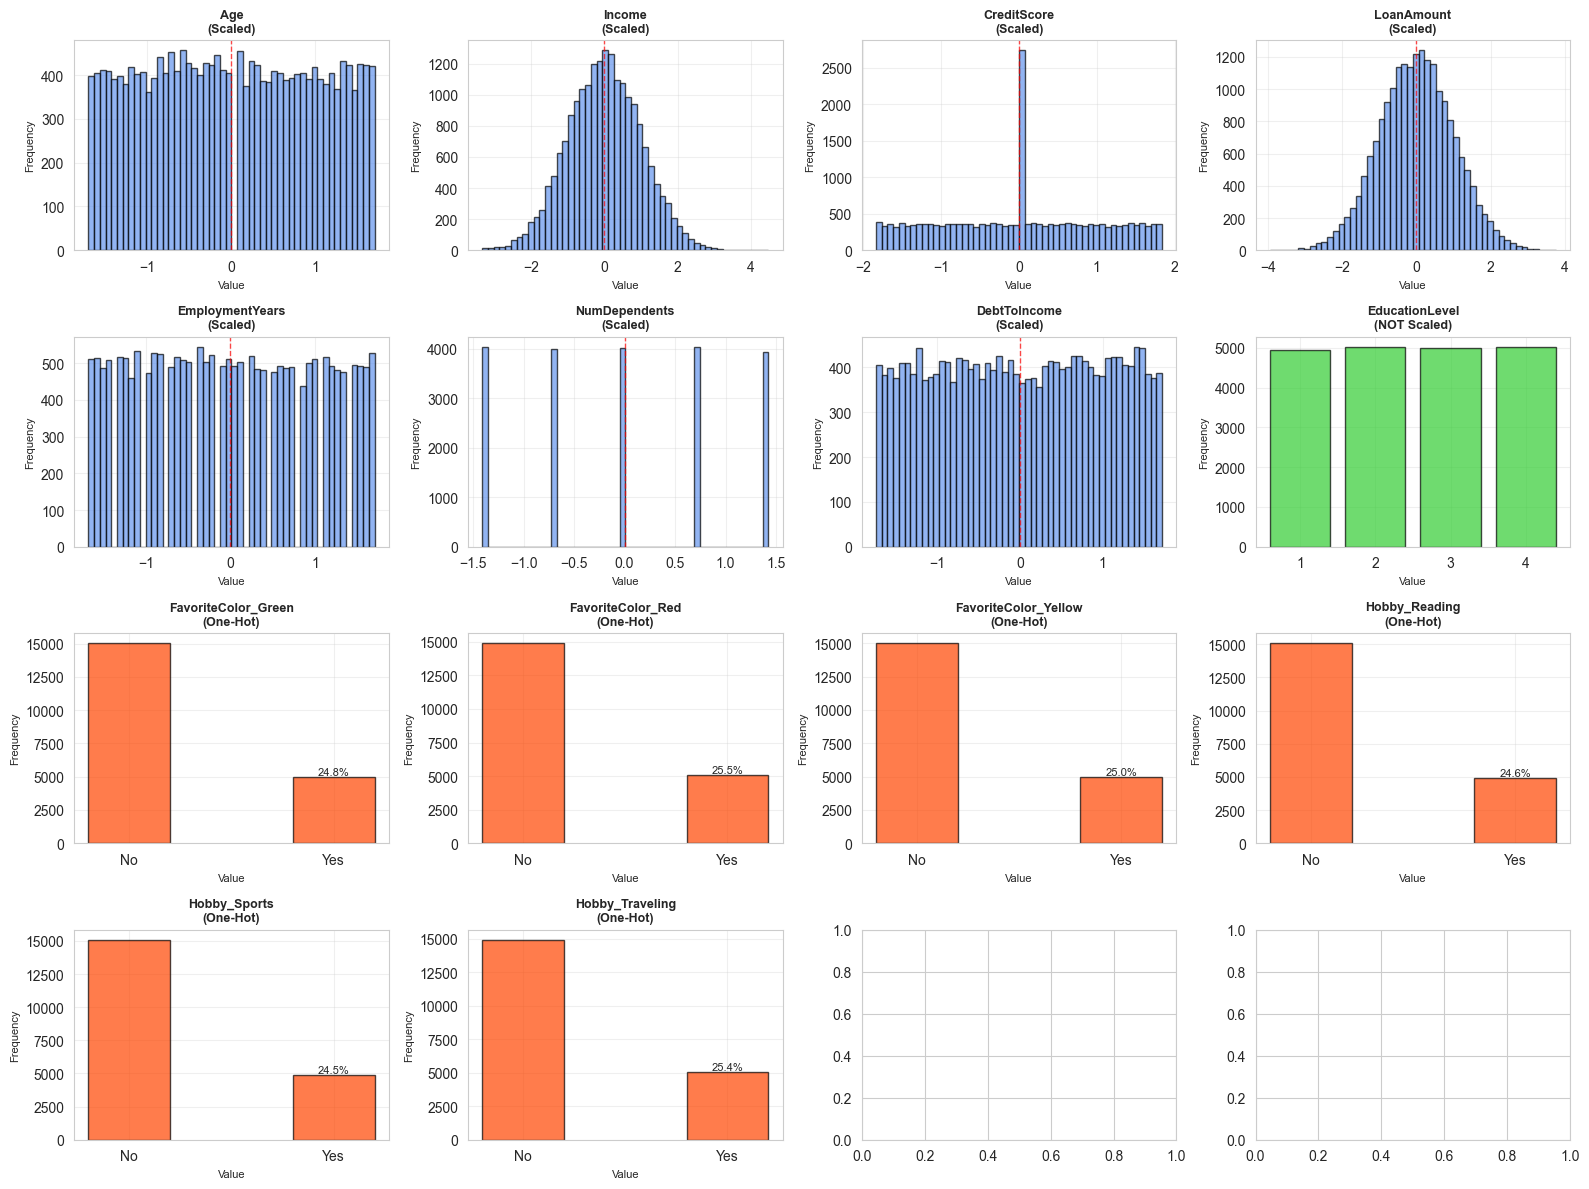

Sample visualization saved to /Users/kryspin/personal/playground/recruitment/challengING_DS/ing_task/output/figures/02_pipeline_B_sample.png

Note: Blue = Scaled numerical
      Green = Ordinal (not scaled)
      Orange/red = One-hot encoded binary


In [89]:
print("\nGenerating Pipeline B sample visualization...")

# show features
features_to_plot = feature_names_B
fig, axes = plt.subplots(4, 4, figsize=(16, 12))
axes = axes.flatten()

for idx, feature in enumerate(features_to_plot):
    ax = axes[idx]
    
    if feature in NUMERICAL_FEATURES:
        ax.hist(train_B_df[feature], bins=50, alpha=0.7, color=Color.BLUE.value, edgecolor=Color.BLACK.value)
        ax.set_title(f'{feature}\n(Scaled)', fontsize=9, fontweight='bold')
        ax.axvline(0, color='red', linestyle='--', linewidth=1, alpha=0.7)
        
    elif feature in ORDINAL_FEATURES:
        ax.hist(train_B_df[feature], bins=np.arange(0.5, 5.5, 1), 
                alpha=0.7, color=Color.GREEN.value, edgecolor=Color.BLACK.value, rwidth=0.8)
        ax.set_title(f'{feature}\n(NOT Scaled)', fontsize=9, fontweight='bold')
        ax.set_xticks([1, 2, 3, 4])
        
    else:
        # categorical: one-hot binary
        counts = train_B_df[feature].value_counts().sort_index()
        ax.bar([0, 1], [counts.get(0, 0), counts.get(1, 0)], 
               alpha=0.7, color=Color.RED.value, edgecolor=Color.BLACK.value, width=0.4)
        ax.set_title(f'{feature}\n(One-Hot)', fontsize=9, fontweight='bold')
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['No', 'Yes'])
        
        # add percentage
        pct_yes = (counts.get(1, 0) / len(train_B_df)) * 100
        ax.text(1, counts.get(1, 0), f'{pct_yes:.1f}%', 
                ha='center', va='bottom', fontsize=8)
    
    ax.set_xlabel('Value', fontsize=8)
    ax.set_ylabel('Frequency', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / '02_pipeline_B_sample.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Sample visualization saved to {FIGURES_DIR / '02_pipeline_B_sample.png'}")
print(f"\nNote: Blue = Scaled numerical")
print(f"      Green = Ordinal (not scaled)")
print(f"      Orange/red = One-hot encoded binary")


Generating visual comparison...


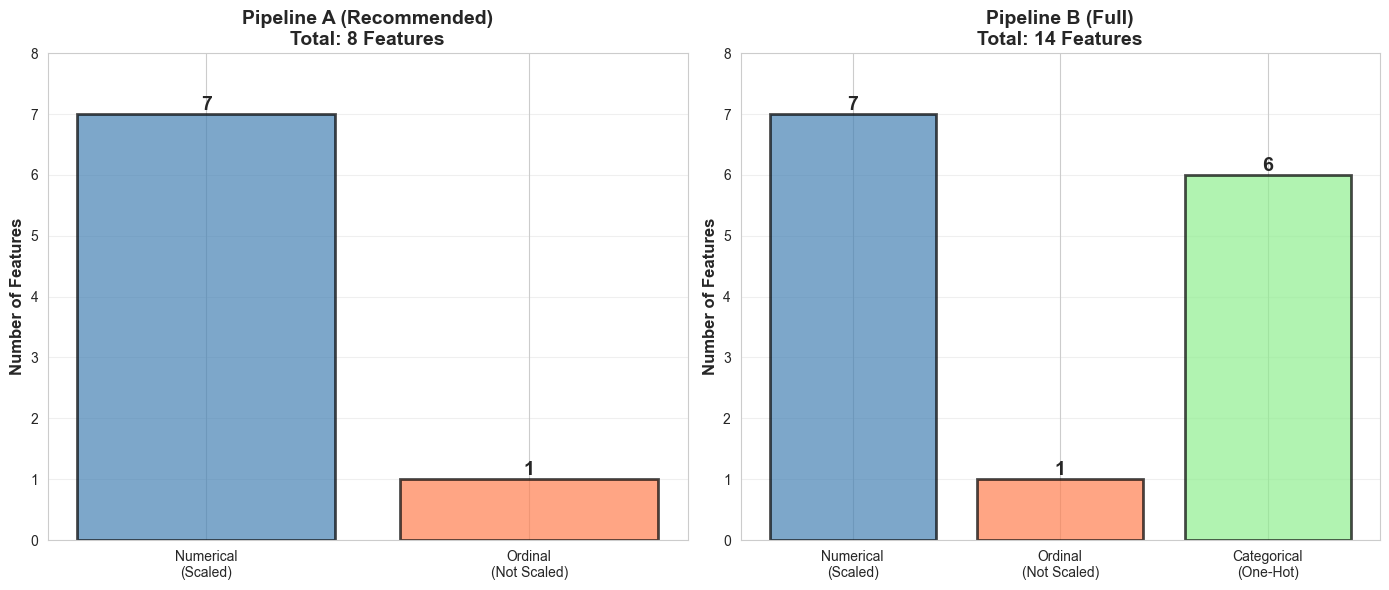

Comparison visualization saved to /Users/kryspin/personal/playground/recruitment/challengING_DS/ing_task/output/figures/02_pipeline_comparison.png


In [73]:
print("\nGenerating visual comparison...")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# pipeline A feature breakdown
ax1 = axes[0]
categories_A = ['Numerical\n(Scaled)', 'Ordinal\n(Not Scaled)']
values_A = [len(NUMERICAL_FEATURES), len(ORDINAL_FEATURES)]
colors_A = ['steelblue', 'coral']
bars_A = ax1.bar(categories_A, values_A, color=colors_A, alpha=0.7, edgecolor='black', linewidth=2)

ax1.set_ylabel('Number of Features', fontsize=12, fontweight='bold')
ax1.set_title('Pipeline A (Recommended)\nTotal: 8 Features', fontsize=14, fontweight='bold')
ax1.set_ylim(0, 8)
ax1.grid(True, axis='y', alpha=0.3)

for bar, val in zip(bars_A, values_A):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{val}', ha='center', va='bottom', fontsize=14, fontweight='bold')

# pipeline B feature breakdown
ax2 = axes[1]
categories_B = ['Numerical\n(Scaled)', 'Ordinal\n(Not Scaled)', 'Categorical\n(One-Hot)']
values_B = [len(NUMERICAL_FEATURES), len(ORDINAL_FEATURES), len(feature_names_categorical)]
colors_B = ['steelblue', 'coral', 'lightgreen']
bars_B = ax2.bar(categories_B, values_B, color=colors_B, alpha=0.7, edgecolor='black', linewidth=2)

ax2.set_ylabel('Number of Features', fontsize=12, fontweight='bold')
ax2.set_title('Pipeline B (Full)\nTotal: 14 Features', fontsize=14, fontweight='bold')
ax2.set_ylim(0, 8)
ax2.grid(True, axis='y', alpha=0.3)

# add value labels on bars
for bar, val in zip(bars_B, values_B):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{val}', ha='center', va='bottom', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(FIGURES_DIR / '02_pipeline_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Comparison visualization saved to {FIGURES_DIR / '02_pipeline_comparison.png'}")

In [78]:
print("\n" + "="*80)
print("DETAILED COMPARISON: Pipeline A vs Pipeline B")
print("="*80)

comparison_detailed = {
    'Aspect': [
        'Total Features',
        'Feature Engineering',
        'Categorical Handling',
        'Training Shape',
        'Test Shape',
        'Training Memory (MB)',
        'Test Memory (MB)',
        'Missing Values',
        'Scaling Applied',
        'Model Compatibility',
        'Interpretability',
        'Expected Performance'
    ],
    'Pipeline A (Recommended)': [
        '8 features',
        'None (baseline)',
        'Dropped (EDA: p=0.879, p=0.636)',
        f'{X_train_A.shape}',
        f'{X_test_A.shape}',
        f'{X_train_A.nbytes / 1024 / 1024:.2f}',
        f'{X_test_A.nbytes / 1024 / 1024:.2f}',
        '0',
        'Numerical only',
        'All models',
        'High (fewer features)',
        'Good (signal only)'
    ],
    'Pipeline B (Full)': [
        '14 features',
        'One-hot encoding',
        'Included for comparison',
        f'{X_train_B.shape}',
        f'{X_test_B.shape}',
        f'{X_train_B.nbytes / 1024 / 1024:.2f}',
        f'{X_test_B.nbytes / 1024 / 1024:.2f}',
        '0',
        'Numerical + one-hot',
        'All models',
        'Lower (more features)',
        'Similar (noise added)'
    ]
}

comparison_df = pd.DataFrame(comparison_detailed)
print("\n")
for _, row in comparison_df.iterrows():
    print(f"{row['Aspect']:25s} | {row['Pipeline A (Recommended)']:35s} | {row['Pipeline B (Full)']}")
    print("-" * 90)

print("\nEDA Prediction: Pipeline A ≈ Pipeline B (categoricals add no value)")
print("Phase 3 will test this empirically with actual model training.")


DETAILED COMPARISON: Pipeline A vs Pipeline B


Total Features            | 8 features                          | 14 features
------------------------------------------------------------------------------------------
Feature Engineering       | None (baseline)                     | One-hot encoding
------------------------------------------------------------------------------------------
Categorical Handling      | Dropped (EDA: p=0.879, p=0.636)     | Included for comparison
------------------------------------------------------------------------------------------
Training Shape            | (20000, 8)                          | (20000, 14)
------------------------------------------------------------------------------------------
Test Shape                | (5000, 8)                           | (5000, 14)
------------------------------------------------------------------------------------------
Training Memory (MB)      | 1.22                                | 2.14
-------------------

In [75]:
print("\n" + "="*80)
print("SAVING PROCESSED DATASETS")
print("="*80)

# Create output directory
PROCESSED_DIR = OUTPUT_DIR / 'processed_data'
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

print(f"\nSaving to: {PROCESSED_DIR}/")

# save Pipeline A outputs
np.save(PROCESSED_DIR / 'X_train_A.npy', X_train_A)
np.save(PROCESSED_DIR / 'X_test_A.npy', X_test_A)
print(f"    X_train_A.npy: {X_train_A.shape}")
print(f"    X_test_A.npy: {X_test_A.shape}")

# save Pipeline B outputs
np.save(PROCESSED_DIR / 'X_train_B.npy', X_train_B)
np.save(PROCESSED_DIR / 'X_test_B.npy', X_test_B)
print(f"    X_train_B.npy: {X_train_B.shape}")
print(f"    X_test_B.npy: {X_test_B.shape}")

# Save target variables (same for both pipelines)
np.save(PROCESSED_DIR / 'y_train.npy', y_train.values)
np.save(PROCESSED_DIR / 'y_test.npy', y_test.values)
print(f"    y_train.npy: {y_train.shape}")
print(f"    y_test.npy: {y_test.shape}")

# Save feature names
FEATURES_PIPELINE_A = NUMERICAL_FEATURES + ORDINAL_FEATURES

with open(PROCESSED_DIR / 'feature_names_A.txt', 'w') as f:
    f.write('\n'.join(FEATURES_PIPELINE_A))
print(f"    feature_names_A.txt: {len(FEATURES_PIPELINE_A)} features")

with open(PROCESSED_DIR / 'feature_names_B.txt', 'w') as f:
    f.write('\n'.join(feature_names_B))
print(f"    feature_names_B.txt: {len(feature_names_B)} features")

print("\nAll datasets saved successfully")


SAVING PROCESSED DATASETS

Saving to: /Users/kryspin/personal/playground/recruitment/challengING_DS/ing_task/output/processed_data/
    X_train_A.npy: (20000, 8)
    X_test_A.npy: (5000, 8)
    X_train_B.npy: (20000, 14)
    X_test_B.npy: (5000, 14)
    y_train.npy: (20000,)
    y_test.npy: (5000,)
    feature_names_A.txt: 8 features
    feature_names_B.txt: 14 features

All datasets saved successfully


In [77]:
print("\n" + "="*80)
print("SAVING FITTED PIPELINES")
print("="*80)

PIPELINE_DIR = OUTPUT_DIR / 'preprocessors'
PIPELINE_DIR.mkdir(parents=True, exist_ok=True)

print(f"\nSaving to: {PIPELINE_DIR}/")

with open(PIPELINE_DIR / 'pipeline_A.pkl', 'wb') as f:
    pickle.dump(pipeline_A, f)
print(f"    pipeline_A.pkl saved")

# Save Pipeline B
with open(PIPELINE_DIR / 'pipeline_B.pkl', 'wb') as f:
    pickle.dump(pipeline_B, f)
print(f"    pipeline_B.pkl saved")

print("\nVerifying saved pipelines...")
with open(PIPELINE_DIR / 'pipeline_A.pkl', 'rb') as f:
    loaded_pipeline_A = pickle.load(f)
print(f"    pipeline_A.pkl loads successfully")

with open(PIPELINE_DIR / 'pipeline_B.pkl', 'rb') as f:
    loaded_pipeline_B = pickle.load(f)
print(f"    pipeline_B.pkl loads successfully")

# test
test_output_A = loaded_pipeline_A.transform(X_train.head())
test_output_B = loaded_pipeline_B.transform(X_train.head())
print(f"\n  Test transform A: {test_output_A.shape}")
print(f"  Test transform B: {test_output_B.shape}")
print(f"  Pipelines work correctly after loading")

print("\nAll pipelines saved successfully")


SAVING FITTED PIPELINES

Saving to: /Users/kryspin/personal/playground/recruitment/challengING_DS/ing_task/output/preprocessors/
    pipeline_A.pkl saved
    pipeline_B.pkl saved

Verifying saved pipelines...
    pipeline_A.pkl loads successfully
    pipeline_B.pkl loads successfully

  Test transform A: (5, 8)
  Test transform B: (5, 14)
  Pipelines work correctly after loading

All pipelines saved successfully
